In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from itertools import *

def print_image(image):
    cv2.namedWindow("Sample Image", cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Sample Image', 800, 800)
    cv2.imshow('Sample Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

shapeX = 0
shapeY = 0

def print_palette(colors):
    palette = np.zeros((100, 1500, 3), dtype=np.uint8)
    for i in range(len(colors)):
        for y in range(100):
            for x in range(int(1500//len(colors))):
                palette[y][i*int(1500//len(colors)) + x] = colors[i]
    
    print_image(palette)

def getPalette(image, diffC):
    palette = []
    paletteColors = []
    paletteColorsPixels = []

    def getNearestColor(color, pixel):
        for i, pColor in enumerate(palette):
            newDst = abs(np.linalg.norm(cv2.add(np.array(color) ,-1*np.array(pColor))))
            if(newDst <= diffC):
                paletteColors[i].append(np.array(color))
                paletteColorsPixels[i].append(pixel)
                # print(cv2.add(np.array(palette[i])*(len(paletteColors[i])-1), np.array(color))/len(paletteColors[i]))
                # palette[i] = np.array(paletteColors[i]).mean(axis = 0)
                palette[i] = cv2.add(np.array(palette[i])*(len(paletteColors[i])-1), np.array(color))/len(paletteColors[i])
                return i
        
        palette.append(color)
        paletteColors.append([color])
        paletteColorsPixels.append([pixel])
        return len(palette)-1

    simpleIndexImage = np.zeros((shapeY,shapeX))

    for y in range(0, shapeY):
        for x in range(0, shapeX):
            simpleIndexImage[y][x] = getNearestColor(image[y][x], [y,x])


    for i in range(len(palette)):
        color = palette[i]
        palette[i] = [int(color[0]), int(color[1]), int(color[2])]
    
    return palette, simpleIndexImage, paletteColorsPixels

step 1: set target image


input:
- result image size (shapeX, shapeY)

- targetImageSrc

- targetImageType

- colorDiff for outline & makepalette

- boxCount for optimize

-> 0~20 sec

output
- outlined image

- simplified image

- color palette

In [2]:
shapeY = 200
shapeX = 200
targetImageSrc = "zr"
targetImageType = ".jpeg"
diff = 40
boxCount = 50



targetImage = cv2.resize(cv2.imread('images/' + targetImageSrc + targetImageType, cv2.IMREAD_COLOR), (shapeX,shapeY),interpolation = cv2.INTER_NEAREST)

outlines = []
boxRangeX = shapeX/boxCount
boxRangeY = shapeY/boxCount
outlineBox = np.zeros((boxCount, boxCount, 0)).tolist()
outlineOnlyImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)
outlinedImage = targetImage.copy()

for y in range(0, shapeY-1):
    for x in range(0, shapeX-1):
        if(abs(np.linalg.norm(cv2.add(targetImage[y][x], -1*targetImage[y+1][x]))) >= diff or 
           abs(np.linalg.norm(cv2.add(targetImage[y][x], -1*targetImage[y][x+1]))) >= diff):
            outlines.append([y,x])
            outlineOnlyImage[y][x] = [255,0,0]
            outlinedImage[y][x] = [0,0,0]
            outlineBox[int(y//boxRangeY)][int(x//boxRangeX)].append([y,x])


targetPalette, simpleIndexTargetImage, targetPaletteColorsPixels = getPalette(outlinedImage, diff)

simpleTargetImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)

for y in range(0, shapeY):
    for x in range(0, shapeX):
        simpleTargetImage[y][x] = targetPalette[int(simpleIndexTargetImage[y][x])]


print_image(outlinedImage)
print_image(simpleTargetImage)
print_palette(targetPalette)

step 2: set colorSheet image


input
- colorSheetImageSrc

- colorSheetImageType

- colorDiff for outline & makepalette

-> 0~20 sec

output
- outlined image

- simplified image

- color palette

In [3]:
colorSheetImageSrc = "slt"
colorSheetImageType = ".jpeg"
colorSheetDiff = 80



colorSheetImage = cv2.resize(cv2.imread('images/' + colorSheetImageSrc + colorSheetImageType, cv2.IMREAD_COLOR), (shapeX,shapeY),interpolation = cv2.INTER_NEAREST)

colorSheetPalette = []
colorSheetPaletteColorsPixels = []

colorSheetOutlines = []
colorSheetOutlineOnlyImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)
colorSheetOutlinedImage = colorSheetImage.copy()

for y in range(0, shapeY-1):
    for x in range(0, shapeX-1):
        if(abs(np.linalg.norm(cv2.add(colorSheetImage[y][x], -1*colorSheetImage[y+1][x]))) >= colorSheetDiff or 
           abs(np.linalg.norm(cv2.add(colorSheetImage[y][x], -1*colorSheetImage[y][x+1]))) >= colorSheetDiff):
            colorSheetOutlines.append([y,x])
            colorSheetOutlineOnlyImage[y][x] = [255,0,0]
            colorSheetOutlinedImage[y][x] = [0,0,0]



colorSheetPalette, simpleIndexColorSheetImage, colorSheetPaletteColorsPixels = getPalette(colorSheetOutlinedImage, colorSheetDiff)

simpleColorSheetImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)

for y in range(0, shapeY):
    for x in range(0, shapeX):
        simpleColorSheetImage[y][x] = colorSheetPalette[int(simpleIndexColorSheetImage[y][x])]


print_image(colorSheetOutlinedImage)
print_image(simpleColorSheetImage)
print_palette(colorSheetPalette)

step 3: generate converted image

-> 0~5 min

In [4]:
def checkBoxImages(boxX,boxY):
    newImage = np.zeros((shapeY, shapeX, 3), dtype=np.uint8)
    print(len(outlineBox[boxY][boxX]))
    for outlinePoint in outlineBox[boxY][boxX]:
        newImage[outlinePoint[0]][outlinePoint[1]] = [255,0,0]
    
    print_image(newImage)

boxCheck = []

def getMinDistanceStart(point):
    boxCheck.clear()
    dstP = getMinDistance(np.array(point), int(point[0]//boxRangeY), int(point[1]//boxRangeX), np.linalg.norm(np.array([shapeY,shapeX])))

    return dstP

def getMinDistance(point, boxY, boxX, minDstP):
    if([boxY, boxX] in boxCheck):
        return minDstP
    else:
        boxCheck.append([boxY, boxX])

    minDst = minDstP
    for outlinePoint in outlineBox[boxY][boxX]:
        dst = np.linalg.norm(np.array(point) - np.array(outlinePoint))
        if(dst < minDst):
            minDst = dst
            

    if(abs(boxRangeX*boxX - point[1]) <= minDst and boxX > 0):
        newDst = getMinDistance(point, boxY, boxX-1, minDst)
        if(newDst < minDst):
            minDst = newDst
    if(abs(boxRangeX*(boxX+1) - point[1]) <= minDst and boxX < boxCount - 1):
        newDst = getMinDistance(point, boxY, boxX+1, minDst)
        if(newDst < minDst):
            minDst = newDst
    if(abs(boxRangeY*boxY - point[0]) <= minDst and boxY > 0):
        newDst = getMinDistance(point, boxY-1, boxX, minDst)
        if(newDst < minDst):
            minDst = newDst
    if(abs(boxRangeY*(boxY+1) - point[0]) <= minDst and boxY < boxCount - 1):
        newDst = getMinDistance(point, boxY+1, boxX, minDst)
        if(newDst < minDst):
            minDst = newDst

    if(minDst < 1):
        return 1

    return minDst

priorityImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)

for y in range(0,shapeY):
    for x in range(0, shapeX):
        dstP = getMinDistanceStart([y,x])
        priorityImage[y][x] = [int(255//(dstP)), int(255//(dstP)), int(255//(dstP))]


stepPixels = {}
steps = []

for y in range(shapeY):
    for x in range(shapeX):
        if(str(priorityImage[y][x][0]) not in stepPixels):
            steps.append(str(priorityImage[y][x][0]))
            stepPixels[str(priorityImage[y][x][0])] = [[y,x]]
        else:
            stepPixels[str(priorityImage[y][x][0])].append([y,x])

steps = sorted(steps, key = lambda x : int(x), reverse=True)

def sortPaletteByVolume(paletteO, paletteColorsPixelsO):
    palette = paletteO.copy()
    paletteColorsPixels = paletteColorsPixelsO.copy()
    for i in range(len(palette) - 1):
        for j in range(i+1, len(palette)):
            if(len(paletteColorsPixels[i]) < len(paletteColorsPixels[j])):
                c = palette[i].copy()
                palette[i] = palette[j].copy()
                palette[j] = c.copy()

                l = paletteColorsPixels[i].copy()
                paletteColorsPixels[i] = paletteColorsPixels[j].copy()
                paletteColorsPixels[j] = l.copy()

    return palette, paletteColorsPixels


targetPalette, targetPaletteColorsPixels = sortPaletteByVolume(targetPalette, targetPaletteColorsPixels)

targetPaletteColorCount = [len(targetPaletteColorsPixels[i]) for i in range(len(targetPaletteColorsPixels))]


colorSheetPalette, colorSheetPaletteColorsPixels = sortPaletteByVolume(colorSheetPalette, colorSheetPaletteColorsPixels)

colorSheetPaletteColorCount = [len(colorSheetPaletteColorsPixels[i]) for i in range(len(colorSheetPaletteColorsPixels))]


colorProportions = np.zeros((len(targetPalette), len(colorSheetPalette)))
colorProportionsPixelCount = np.zeros((len(targetPalette), len(colorSheetPalette)))


resultColorCount = 0
indices = np.arange(len(colorSheetPalette))
mergeColorCount = 1
colorSheetPaletteColorCountUsable = colorSheetPaletteColorCount.copy()
doneTargetColors = np.zeros((len(targetPalette)))

while(resultColorCount < len(targetPalette) and mergeColorCount <= len(colorSheetPalette)):
    mergeColors = list(combinations(indices, mergeColorCount))
    for i in range(len(mergeColors)):
        cnt = 0

        colors = mergeColors[i]

        doCheck = True

        for j in colors:
            if(colorSheetPaletteColorCountUsable[j] <= 0): doCheck = False
            else : cnt += colorSheetPaletteColorCountUsable[j]
        
        if(doCheck == False):
            continue

        colorMakeIdx = -1
        for k in range(len(targetPalette)):
            if(cnt >= targetPaletteColorCount[len(targetPalette) - 1 - k]):
                if(doneTargetColors[len(targetPalette) - 1 - k] != 1):
                    colorMakeIdx = len(targetPalette) - 1 - k
                else:
                    pass
            else:
                break
        
        
        if(colorMakeIdx != -1):
            colors = sorted(mergeColors[i], key = lambda x : colorSheetPaletteColorCountUsable[x])
            cnt = 0
            amount = -1
            amountPixel = -1

            for j in colors:
                doneTargetColors[colorMakeIdx] = 1

                if(targetPaletteColorCount[colorMakeIdx] - cnt > colorSheetPaletteColorCountUsable[j]):
                    colorProportions[colorMakeIdx][j] = round(colorSheetPaletteColorCountUsable[j] / targetPaletteColorCount[colorMakeIdx], 3)
                    colorProportionsPixelCount[colorMakeIdx][j] = colorSheetPaletteColorCountUsable[j]
                    cnt += colorSheetPaletteColorCountUsable[j]
                    colorSheetPaletteColorCountUsable[j] = 0
                else:
                    if((colors.index(j)) == len(colors) - 1):
                        colorProportionsPixelCount[colorMakeIdx][j] = targetPaletteColorCount[colorMakeIdx] - cnt
                        colorProportions[colorMakeIdx][j] = round(targetPaletteColorCount[colorMakeIdx] - cnt / targetPaletteColorCount[colorMakeIdx], 3)
                        colorSheetPaletteColorCountUsable[j] -= targetPaletteColorCount[colorMakeIdx] - cnt
                        
                    else:
                        if(amount < 0): 
                            amount = 1//(len(colors) - (colors.index(j))) * (targetPaletteColorCount[colorMakeIdx] - cnt)
                            amountPixel = amount
                            
                        colorProportions[colorMakeIdx][j] = round(amount / targetPaletteColorCount[colorMakeIdx], 3)
                        colorProportionsPixelCount[colorMakeIdx][j] = amount
                        cnt += amount
                        colorSheetPaletteColorCountUsable[j] -= amount
                
                if(colorSheetPaletteColorCountUsable[j] <= 0):
                    indices = np.delete(indices, list(indices).index(j))

            resultColorCount += 1
    
    print(mergeColorCount)
    mergeColorCount += 1
    
if(resultColorCount < len(targetPalette)):
    print("failed")


for i in range(len(colorSheetPalette)):
    colorSheetPaletteColorsPixels[i] = sorted(colorSheetPaletteColorsPixels[i], key = lambda x : (abs(np.linalg.norm(cv2.add(np.array(colorSheetPalette[i]), -1*np.array(x))))))


def getIndex(l, a):
    for i in range(len(l)):
        if(all(l[i] == a)):
            return i
    
    return 0

def getColor(proportionRange):

    colorIdx = -1

    rand = np.random.rand(1)

    for i in range(len(proportionRange)):
        if((rand <= proportionRange[i] and proportionRange[i] != 0)):
            colorIdx = i
            break

    return colorIdx

def getProportionRange(proportionPixelCount):
    proportionPixelCountRange = proportionPixelCount.copy()
    cnt = 0
    for i in range(len(proportionPixelCount)):
        if(proportionPixelCount[i] != 0):
            cnt += proportionPixelCount[i]
            proportionPixelCountRange[i] = cnt

    return np.array(proportionPixelCountRange) / cnt



resultImage = np.zeros((shapeY,shapeX,3), dtype=np.uint8)
resultPosImage = np.zeros((shapeY, shapeX, 2))

cntNull = 0 #예외케이스를 잡기 위한 카운트
colorProportionsPixelCountCopy = colorProportionsPixelCount.copy()
colorSheetPaletteColorsPixelsIdx = np.zeros((len(colorSheetPalette)), dtype=np.int64)

for step in steps:
    for y,x in stepPixels[step]:
        pixelColor = simpleTargetImage[y][x]
        pixelColorIdx = getIndex(targetPalette, pixelColor)

        pixelColorProportionRange = getProportionRange(colorProportionsPixelCountCopy[pixelColorIdx])
        
        newPixelColorIdx = getColor(pixelColorProportionRange)

        if(newPixelColorIdx != -1):
            
            pixelPosition = colorSheetPaletteColorsPixels[newPixelColorIdx][colorSheetPaletteColorsPixelsIdx[newPixelColorIdx]]
            newPixelColor = colorSheetImage[pixelPosition[0]][pixelPosition[1]]
            resultImage[y][x] = newPixelColor
            resultPosImage[pixelPosition[0]][pixelPosition[1]] = [y,x]


            colorSheetPaletteColorsPixelsIdx[newPixelColorIdx] += 1
            colorProportionsPixelCountCopy[pixelColorIdx][newPixelColorIdx] -= 1

        else:
            cntNull += 1
            resultImage[y][x] = [255,0,0]


print_image(resultImage)

1
2
3
4
5


In [7]:
print_image(resultImage)

step 4 : make animation

input:
- beforeChangeFrame
- changeFrame
- afterChangeFrame
- fps

output:
- delay beforeChangeFrame, change while changeFrame, remain afterChangeFrame

In [37]:
beforeChangeFrame = 30
changeFrame = 180
afterChangeFrame = 30
fps = 60
figsize = 8

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(frameon=False)
fig.set_size_inches(figsize * 2 * (shapeX) / (shapeX + shapeY), figsize * 2 * (shapeY) / (shapeX + shapeY))
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.ffmpeg_path'] = r'/opt/homebrew/Cellar/ffmpeg/8.0.1/bin/ffmpeg'
plt.ioff()

pltXoriginal = []
pltYoriginal = []
pltXtarget = []
pltYtarget = []
pltColor = []


for y in range(shapeY):
    for x in range(shapeX):
        pltXoriginal.append(x)
        pltYoriginal.append(shapeY - y)
        pltColor.append(np.array(colorSheetImage[y][x][::-1])/255)
        targetPos = resultPosImage[y][x]
        pltXtarget.append(targetPos[1])
        pltYtarget.append(shapeY - targetPos[0])

pltXoriginal = np.array(pltXoriginal)
pltYoriginal = np.array(pltYoriginal)
pltXtarget = np.array(pltXtarget)
pltYtarget = np.array(pltYtarget)

markersize = ((2 * fig.dpi * figsize /(shapeX + shapeY))/4)**2

def animate(t):
    f = changeFrame - beforeChangeFrame
    if(t - beforeChangeFrame < 0 or t > beforeChangeFrame + changeFrame):
        pass
    else:
        fx = ((changeFrame - (t - beforeChangeFrame))*pltXoriginal + ((t - beforeChangeFrame))*pltXtarget)/changeFrame
        fy = ((changeFrame - (t - beforeChangeFrame))*pltYoriginal + ((t - beforeChangeFrame))*pltYtarget)/changeFrame
        plt.cla()
        plt.xlim(0,shapeX)
        plt.ylim(0,shapeY)
        plt.scatter(fx, fy, c = pltColor, marker='s', s = markersize)

plt.cla() 
plt.xlim(0,shapeX)
plt.ylim(0,shapeY)
plt.scatter(pltXoriginal, pltYoriginal, c = pltColor, marker='s', s = markersize)
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=beforeChangeFrame + changeFrame + afterChangeFrame, interval=1000/fps, repeat = False)


writer = matplotlib.animation.FFMpegFileWriter(fps = fps)
anim.save("videos/" + colorSheetImageSrc + "_to_" + targetImageSrc +".mp4", writer='ffmpeg')

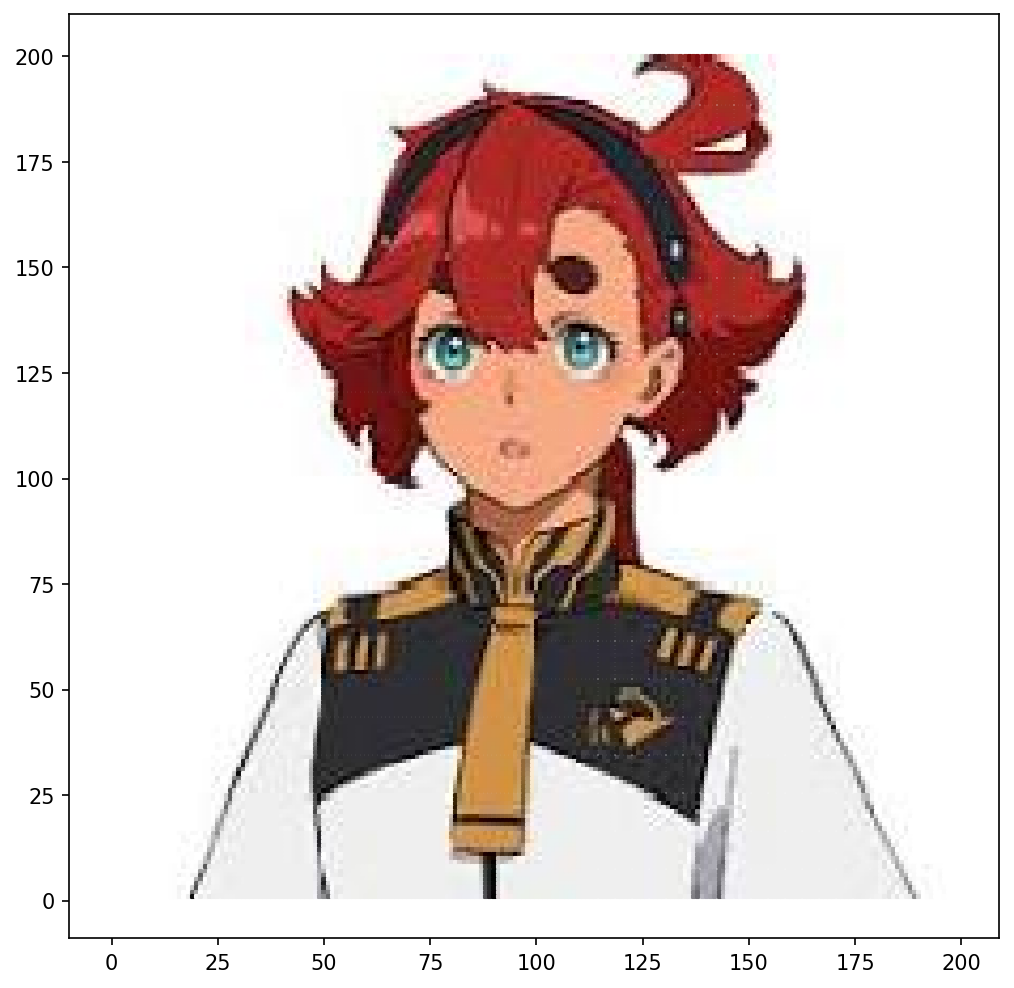

6.0


In [32]:
fig = plt.figure(frameon=False)
fig.set_size_inches(8,8)
plt.scatter(pltXoriginal, pltYoriginal, c = pltColor, marker='s', s = ((fig.dpi * 8 / 200)/4)**2)
plt.show()

print(fig.dpi * 8 / 200)

In [28]:
print(fig.get_size_inches())

[8. 8.]
